# 统计方法与机器学习-实验报告3

温兆和 10205501432

## 背景描述

实验研究了操作温度和三种面板玻璃材料对示波器管输出光的影响。

这是一个压力（因子$A$）水平数$a=3$，温度（因子$B$）水平数$b=3$和重复次数$m=3$的双因子实验。

## 数据描述
|   变量名   |   变量含义   | 变量类型 |     变量取值范围     |
| :---------------:|:------------------------:|:-------------------:|:-------------------:|
|Glass_Type|玻璃材料类型|分类变量|{1,2,3}|
|Temperature|操作温度|连续变量|{100,125,150}|
|Light_Output|输出光|连续变量|$R$|

显著性水平$α$取 0.05。

## 实验过程

- 判断面板玻璃类型和操作温度对该仪器的输出光是否有显著影响。面板玻璃类型和操作温度是否存在交互作用？

我们先引入本次实验所要用到的Python库，并打开数据集：

In [5]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from jupyterquiz import display_quiz 
from itertools import product

import statsmodels.api
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
print('ProjectData is shown as follows: \n', pd.read_csv("./Project_2.csv"))

ProjectData is shown as follows: 
     Glass_Type  Temperature  Light_Output
0            1          100           580
1            1          100           568
2            1          100           570
3            2          100           550
4            2          100           530
5            2          100           579
6            3          100           546
7            3          100           575
8            3          100           599
9            1          125          1090
10           1          125          1087
11           1          125          1085
12           2          125          1070
13           2          125          1035
14           2          125          1000
15           3          125          1045
16           3          125          1053
17           3          125          1066
18           1          150          1392
19           1          150          1380
20           1          150          1386
21           2          150          1328

可以发现，这个数据集中响应变量为输出光，影响该响应变量的共有玻璃材料类型和操作温度两个因子，每个因子各有三个水平，每种因子组合下各有三次重复。由此，我们来设置该双因子方差分析问题的一些参数：

In [6]:
alpha = 0.05 #显著性水平
a = 3        #玻璃材料类型因子数
b = 3        #操作温度因子数
m = 3        #每种因子组合下的重复次数

在双因子方差分析问题中，我们假设$$y_{ijk} = \mu + \alpha_i + \beta_j + (\alpha\beta)_{ij} + \epsilon_{ijk}$$其中$$\sum_{i=1}^a \alpha_i=0,\sum_{j=1}^b \beta_j=0,\sum_{i=1}^a (\alpha\beta)_{ij}=\sum_{j=1}^b (\alpha\beta)_{ij}=0$$假设$$\epsilon_{ijk} \overset{i.i.d}{\sim} N(0,\sigma^2)$$
于是，判断面板玻璃类型和操作温度对该仪器的输出光是否有显著影响以及面板玻璃类型和操作温度是否存在交互作用的问题就可以转化为下面的假设检验问题：

判断面板玻璃类型对该仪器的输出光是否有显著影响：$$H_0:\alpha_1=\alpha_2=\alpha_3=0 v.s. H_1:\exists i\in\{1,2,3\} s.t. \alpha_i\neq 0$$
判断操作温度对该仪器的输出光是否有显著影响：$$H_0:\beta_1=\beta_2=\beta_3=0 v.s. H_1:\exists j\in\{1,2,3\} s.t. \beta_j\neq 0$$
判断面板玻璃类型和操作温度是否存在交互作用：$$H_0:对\forall i\in\{1,2,3\},j\in\{1,2,3\},(\alpha\beta)_{ij}=0 v.s. H_1:\exists (\alpha\beta)_{ij}\neq 0$$
我们用Python内置的函数对这三个问题进行检验：

In [7]:
Data = pd.read_csv('./Project_2.csv')
model = ols('Light_Output ~ C(Glass_Type) * C(Temperature)', Data).fit()
anova_results = anova_lm(model)
print("Two-way ANOVA Table is shown as follows: \n", round(anova_results,4))

Two-way ANOVA Table is shown as follows: 
                                 df        sum_sq      mean_sq          F  \
C(Glass_Type)                  2.0  1.508645e+05   75432.2593   206.3706   
C(Temperature)                 2.0  1.970335e+06  985167.2593  2695.2595   
C(Glass_Type):C(Temperature)   4.0  2.905517e+05   72637.9259   198.7257   
Residual                      18.0  6.579333e+03     365.5185        NaN   

                              PR(>F)  
C(Glass_Type)                    0.0  
C(Temperature)                   0.0  
C(Glass_Type):C(Temperature)     0.0  
Residual                         NaN  


可见，在显著性水平$α=0.05$下，三个检验的$p$值都为$0$.所以我们认为面板玻璃类型和操作温度对该仪器的输出光的影响以及面板玻璃类型和操作温度之间的交互作用都是显著的.

- 用适合的残差图，判断任务1中使用的模型是否恰当？

为了验证模型的合理性，我们研究$$\epsilon_{ijk}=y_{ijk} -\mu -\alpha_i-\beta_j+(\alpha\beta)_{ij}$$的分布是否满足独立性、正态性、方差齐性。由于误差是难以观测的，所以我们用残差（即数据真实值与估计值之差）$$e_{ijk}=y_{ijk} -\hat{ \mu} -\hat{ \alpha_i }-\hat{ \beta_j }+\hat{ (\alpha\beta)_{ij}}$$来代替误差。

我们先计算出各因子水平组合下数据的残差：

In [8]:
Data_values = Data.values
data_res = Data_values.astype(float)
Data["Fitted_Values"] = model.predict()
Data["Residuals"] = Data["Light_Output"] - model.predict()
print("The residuals are as follows: \n", Data["Residuals"])

The residuals are as follows: 
 0     7.333333e+00
1    -4.666667e+00
2    -2.666667e+00
3    -3.000000e+00
4    -2.300000e+01
5     2.600000e+01
6    -2.733333e+01
7     1.666667e+00
8     2.566667e+01
9     2.666667e+00
10   -3.333333e-01
11   -2.333333e+00
12    3.500000e+01
13   -4.547474e-13
14   -3.500000e+01
15   -9.666667e+00
16   -1.666667e+00
17    1.133333e+01
18    6.000000e+00
19   -6.000000e+00
20    0.000000e+00
21    1.500000e+01
22   -1.000000e+00
23   -1.400000e+01
24   -1.966667e+01
25    1.733333e+01
26    2.333333e+00
Name: Residuals, dtype: float64


接着，我们用Durbin-Watson方法检验误差的独立性。

In [9]:
DW = durbin_watson(Data["Residuals"])
print("DW statistic is", round(DW,4))

DW statistic is 2.2731


可见，我们得到的数值比较接近于$2$，所以可以认为误差之间是相互独立的。

接着，我们用Bartlett方法和修正后的Levene方法分别验证在不同因子影响下响应变量的误差方差相等。

In [10]:
Bart_stat, Bart_pVal = stats.bartlett([580,568,570],[550,530,579],[546,575,599],[1090,1087,1085],[1070,1035,1000],[1045,1053,1066],[1392,1380,1386],[1328,1312,1299],[867,904,889])
print("Bartlett's test statistic is", round(Bart_stat,4))
print("The p value is", round(Bart_pVal,4))

Bartlett's test statistic is 13.4386
The p value is 0.0976


由于$p$值大于显著性水平$\alpha=0.05$，我们接受原假设，认为这个数据集中不同因子水平影响下的数方差相等。

用修正后的Levene检验也能得出同样的结论：

In [11]:
Lev_stat, Lev_pVal = stats.levene([580,568,570],[550,530,579],[546,575,599],[1090,1087,1085],[1070,1035,1000],[1045,1053,1066],[1392,1380,1386],[1328,1312,1299],[867,904,889])
print("Levene's test statistic is", round(Lev_stat,4))
print("The p value is", round(Lev_pVal,4))

Levene's test statistic is 1.2548
The p value is 0.3253


这里的$p$值也是大于显著性水平的，所以一样可以得到数据集中不同因子水平影响下的数方差相等的结论。

最后，我们用Shapiro-Wilk方法检验误差的正态性。

In [12]:
SW_stat,SW_pVal = stats.shapiro(Data["Residuals"])
print("Shapiro-Wilk test statistic is", round(SW_stat,4))
print("The p value is", round(SW_pVal,4))

Shapiro-Wilk test statistic is 0.967
The p value is 0.5237


由于$p$值大于显著性水平$\alpha=0.05$，我们接受原假设，认为残差是服从正态分布的。

- 选出一种合适的玻璃类型，并给出理由。

我们对数据进行进一步处理，并根据响应变量在不同因子水平组合下的预测值作图。

    Glass_Type  Temperature  Fitted_Values
0            1          100     572.666667
3            2          100     553.000000
6            3          100     573.333333
9            1          125    1087.333333
12           2          125    1035.000000
15           3          125    1054.666667
18           1          150    1386.000000
21           2          150    1313.000000
24           3          150     886.666667


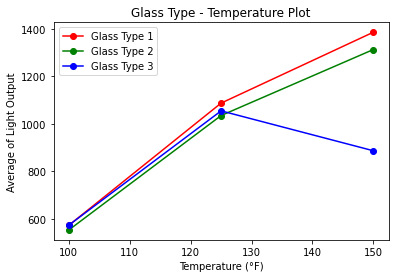

In [13]:
Data1 = Data.drop(labels = ["Light_Output","Residuals"],axis = 1)
Data2 = Data1.drop_duplicates(subset = None,keep = "first",inplace = False)
print(Data2)
MT = Data["Glass_Type"].unique()
for temp_MT in MT:
    temp_data = Data2[Data2["Glass_Type"].isin([temp_MT])]
    exec("Data2_%s = temp_data"%temp_MT)
plt.plot(Data2_1["Temperature"],Data2_1["Fitted_Values"], color = 'red', marker = 'o', label = 'Glass Type 1')
plt.plot(Data2_2["Temperature"],Data2_2["Fitted_Values"], color = 'green', marker = 'o', label = 'Glass Type 2')
plt.plot(Data2_3["Temperature"],Data2_3["Fitted_Values"], color = 'blue', marker = 'o', label = 'Glass Type 3')
plt.title("Glass Type - Temperature Plot")
plt.xlabel("Temperature (°F)")
plt.ylabel("Average of Light Output")
plt.legend(['Glass Type 1', 'Glass Type 2', 'Glass Type 3'])

可见，第一种玻璃在不同的温度水平下都有较高的输出光，所以我们选择第一种玻璃。

- 绘制响应曲线，并预测在操作温度为$110$度时，三种不同面板玻璃类型制成的仪器的输出光分别为多少？

现在，我们用线性回归的方法对刚刚处理得到的数据进行拟合，并画出更为光滑、更能反映响应变量在所有不同温度下的输出光的图表，从而预测不同种类玻璃在特定温度下输出光的取值。

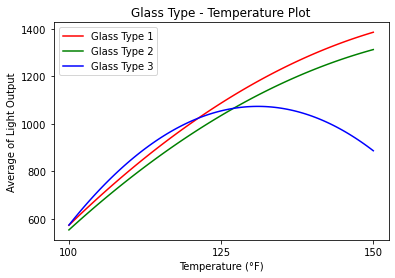

In [36]:
A = (Data.values[:,1] - np.mean(Data["Temperature"]))*2 / (np.max(Data["Temperature"]) - np.min(Data["Temperature"])) 
B1 = Data.values[:,0]
B2 = Data.values[:,0]
for i in range(Data.shape[0]):
    if Data["Glass_Type"][i] == 1:
        B1[i] = 1
        B2[i] = 0
    if Data["Glass_Type"][i] == 2:
        B1[i] = 0
        B2[i] = 1
    if Data["Glass_Type"][i] == 3:
        B1[i] = -1
        B2[i] = -1  
AA = A**2
AB1 = A * B1
AB2 = A * B2
AAB1 = AA * B1
AAB2 = AA * B2

Data3 = pd.DataFrame(A,columns=["A"])
Data3["B1"] = B1
Data3["B2"] = B2
Data3["AA"] = AA
Data3["AB1"] = AB1
Data3["AB2"] = AB2
Data3["AAB1"] = AAB1
Data3["AAB2"] = AAB2
Data3["Light_Output"] = Data["Light_Output"]
model_new = ols('Light_Output ~ A+B1+B2+AA+AB1+AB2+AAB1+AAB2', Data3).fit()
model_new.summary()
A_new = list(np.linspace(start = -1,stop = 1, num = 100)) # num = 50 (default)
B_new = [1,2,3]
Data4 = pd.DataFrame(index = range(len(A_new)*len(B_new)),columns=["A","B1","B2","AA","AB1","AB2","AAB1","AAB2"])
for i in range(len(A_new)):
    for j in range(len(B_new)):
        Data4["A"][i*len(B_new)+j] = A_new[i]
        if B_new[j] == 1:
            Data4["B1"][i*len(B_new)+j] = 1
            Data4["B2"][i*len(B_new)+j] = 0
        if B_new[j] == 2:
            Data4["B1"][i*len(B_new)+j] = 0
            Data4["B2"][i*len(B_new)+j] = 1
        if B_new[j] == 3:
            Data4["B1"][i*len(B_new)+j] = -1
            Data4["B2"][i*len(B_new)+j] = -1

Data4["AA"] = Data4["A"] **2
Data4["AB1"] = Data4["A"] * Data4["B1"]
Data4["AB2"] = Data4["A"] * Data4["B2"]
Data4["AAB1"] = Data4["AA"] * Data4["B1"]
Data4["AAB2"] = Data4["AA"] * Data4["B2"]  
Data4 = statsmodels.api.add_constant(Data4)
Data4["Fitted_Values"] = np.dot(Data4,model_new.params)
list_B1 = Data4["B1"].unique()
index = 1
for temp in list_B1:
    temp_data = Data4[Data4["B1"].isin([temp])]
    exec("Data4_%s = temp_data"%index)
    index += 1


plt.plot(Data4_1["A"],Data4_1["Fitted_Values"], color = 'red', label = 'Glass Type 1')
plt.plot(Data4_2["A"],Data4_2["Fitted_Values"], color = 'green',  label = 'Glass Type 2')
plt.plot(Data4_3["A"],Data4_3["Fitted_Values"], color = 'blue',  label = 'Glass Type 3')
plt.title("Glass Type - Temperature Plot")
plt.xlabel("Temperature (°F)")
plt.ylabel("Average of Light Output")
plt.xticks([-1,0,1],[100,125,150])
plt.legend(['Glass Type 1', 'Glass Type 2', 'Glass Type 3'])

可以预测，三种材料在$110$度温度下的输出光都在$800$左右。